In [417]:
#####Variable order Tensor Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

In [418]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [138]:
####データの発生####
##データの設定
#要素ごとのユニーク数を設定
k = 10
days = 2000
company = 2000
area = 125
item = 1000
subject = 600
element = 500
trend = 3

#要素ごとの頻度を生成
Z = np.random.binomial(1, np.tile(np.random.beta(5.0, 4.0, company), days), company*days).reshape(company, days, order="F")
pt1 = np.sum(Z, axis=0)
pt2 = np.sum(Z, axis=1)
m = np.random.poisson(np.random.gamma(20.0, 1/0.25, days))
N = np.sum(Z)
M = np.sum(m)

In [421]:

area_id

array([59, 18, 96, ..., 88, 59, 70])

In [139]:
##idとインデックスの設定
#idの設定
company_id = np.tile(np.arange(company), days)[Z.T.reshape(-1)==1]
pt_id = np.repeat(np.arange(days), pt1)
m_id = np.repeat(np.arange(days), m)

#インデックスの設定
company_index = [i for i in range(company)]
pt_index = [j for j in range(days)]
m_index = [j for j in range(days)]
m_vec = [j for j in range(days)]
for i in range(company):
    company_index[i] = np.array(np.where(company_id==i)[0], dtype="int")
for j in range(days):
    pt_index[j] = np.array(np.where(pt_id==j)[0], dtype="int")
    m_index[j] = np.array(np.where(m_id==j)[0], dtype="int")
    m_vec[j] = np.repeat(1, m[j]) 

In [140]:
##アイテムを生成
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #多項分布からトピックを生成
    topic = 20
    theta = np.zeros((days, topic))
    for j in range(days):
        if j==0:
            theta[j, ] = np.random.dirichlet(np.repeat(0.2, topic), 1)
        else:
            theta[j, ] = np.random.dirichlet(theta[j-1, ] + np.repeat(0.2, topic))
    z = np.dot(np.array(rmnom(theta[m_id, ], M, topic, np.arange(M)).todense()), np.arange(topic))

    #トピックからアイテムを生成
    phi_area = np.random.dirichlet(np.repeat(0.1, area), topic)
    phi_item = np.random.dirichlet(np.repeat(0.1, item), topic)
    phi_subject = np.random.dirichlet(np.repeat(0.1, subject), topic)
    phi_element = np.random.dirichlet(np.repeat(0.1, element), topic)
    phi_trend = np.random.dirichlet(np.repeat(0.1, trend), topic)
    area_id = np.dot(np.array(rmnom(phi_area[z, ], M, area, np.arange(M)).todense()), np.arange(area))
    item_id = np.dot(np.array(rmnom(phi_item[z, ], M, item, np.arange(M)).todense()), np.arange(item))
    subject_id = np.dot(np.array(rmnom(phi_subject[z, ], M, subject, np.arange(M)).todense()), np.arange(subject))
    element_id = np.dot(np.array(rmnom(phi_element[z, ], M, element, np.arange(M)).todense()), np.arange(element))
    trend_id = np.dot(np.array(rmnom(phi_trend[z, ], M, trend, np.arange(M)).todense()), np.arange(trend))

    #一定確率で欠損を挿入
    item_id[np.random.binomial(1, 0.3, M)==1] = item
    subject_id[np.random.binomial(1, 0.5, M)==1] = subject
    element_id[np.random.binomial(1, 0.25, M)==1] = element
    trend_id[np.random.binomial(1, 0.15, M)==1] = trend

    #すべてのアイテムが存在していればbreak
    if (np.unique(subject_id).shape[0]==(subject + 1)) & (np.unique(item_id).shape[0]==(item + 1)) &\
            (np.unique(element_id).shape[0]==(element + 1)):
        break
        
#インデックスを設定
area_index = [j for j in range(area)]
item_index = [j for j in range(item)]
subject_index = [j for j in range(subject)]
element_index = [j for j in range(element)]
trend_index = [j for j in range(trend)]
for j in range(area):
    area_index[j] = np.array(np.where(area_id==j)[0], dtype="int")
for j in range(item):
    item_index[j] = np.array(np.where(item_id==j)[0], dtype="int")
for j in range(subject):
    subject_index[j] = np.array(np.where(subject_id==j)[0], dtype="int")
for j in range(element):
    element_index[j] = np.array(np.where(element_id==j)[0], dtype="int")
for j in range(trend):
    trend_index[j] = np.array(np.where(trend_id==j)[0], dtype="int")

1
2


In [141]:
##VoTDの応答変数を生成
#事前分布のパラメータを設定
alpha1 = np.array([0])
alpha2 = np.repeat(0, k)
tau_c = np.array([0.5]); tau_d = np.array([0.5])
Cov_c = np.diag(np.repeat(0.3, k))
Cov_a = np.diag(np.repeat(0.25, k))
Cov_i = np.diag(np.repeat(0.25, k))
Cov_s = np.diag(np.repeat(0.25, k))
Cov_e = np.diag(np.repeat(0.25, k))
Cov_t = np.diag(np.repeat(0.25, k))
alphat1 = alpha1.copy(); alphat2 = alpha2.copy()
taut_c = tau_c.copy(); taut_d = tau_d.copy()
Covt_c = Cov_c.copy(); Covt_a = Cov_a.copy(); Covt_i = Cov_i.copy()
Covt_s = Cov_s.copy(); Covt_e = Cov_e.copy(); Covt_t = Cov_t.copy()

#モデルパラメータを生成
Sigma = np.array([0.2])
beta = np.array([0.0])
beta_c = np.random.normal(alpha1, tau_c, company); beta_d = np.random.normal(alpha1, tau_d, days)
theta_c = np.random.multivariate_normal(alpha2, Cov_c, company)
theta_a = np.random.multivariate_normal(alpha2, Cov_a, area)
theta_i = np.vstack((np.random.multivariate_normal(alpha2, Cov_i, item), np.repeat(1, k)))
theta_s = np.vstack((np.random.multivariate_normal(alpha2, Cov_s, subject), np.repeat(1, k)))
theta_e = np.vstack((np.random.multivariate_normal(alpha2, Cov_e, element), np.repeat(1, k)))
theta_t = np.vstack((np.random.multivariate_normal(alpha2, Cov_t, trend), np.repeat(1, k)))
Sigmat = Sigma.copy(); betat = beta.copy(); betat_c = beta_c.copy(); betat_d = beta_d.copy()
thetat_c = theta_c.copy(); thetat_a = theta_a.copy(); thetat_i = theta_i.copy()
thetat_s = theta_s.copy(); thetat_e = theta_e.copy(); thetat_t = theta_t.copy()

(array([2.00000e+00, 7.00000e+00, 1.50000e+01, 7.10000e+01, 2.32000e+02,
        7.09000e+02, 2.19900e+03, 7.52600e+03, 2.29840e+04, 6.69490e+04,
        1.75068e+05, 3.67374e+05, 5.41234e+05, 5.05416e+05, 3.06960e+05,
        1.36039e+05, 5.10760e+04, 1.72170e+04, 5.48100e+03, 1.73300e+03,
        5.30000e+02, 1.65000e+02, 5.60000e+01, 1.10000e+01, 3.00000e+00]),
 array([-14.13069232, -13.03373243, -11.93677254, -10.83981265,
         -9.74285276,  -8.64589287,  -7.54893298,  -6.4519731 ,
         -5.35501321,  -4.25805332,  -3.16109343,  -2.06413354,
         -0.96717365,   0.12978623,   1.22674612,   2.32370601,
          3.4206659 ,   4.51762579,   5.61458568,   6.71154557,
          7.80850545,   8.90546534,  10.00242523,  11.09938512,
         12.19634501,  13.2933049 ]),
 <a list of 25 Patch objects>)

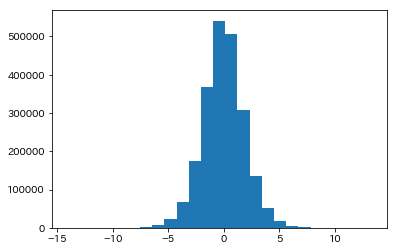

In [142]:
#期待値を設定
theta_prod = theta_a[area_id, ] * theta_i[item_id, ] * theta_s[subject_id, ] * theta_e[element_id, ] * theta_t[trend_id, ]
theta_w = np.zeros((days, k))
for j in range(days):
    theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
uv = np.dot(theta_c[company_id, ] * theta_w[pt_id, ], np.repeat(1, k))
mu = beta + beta_c[company_id] + beta_d[pt_id] + uv

#正規分布から応答変数を生成
y = mu + np.random.normal(0, Sigma, N)
y_vec = y[:, np.newaxis]
plt.hist(y, bins=25)

In [143]:
##テストデータの作成

In [144]:
####マルコフ連鎖モンテカルロ法でariable order Tensor Decompositionを推定####
##アルゴリズムの設定
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 4
e1 = 0.001
e2 = 0.001
L = 3

In [145]:
##観測レコードと観測データをインデックスで対応付ける
#areaのインデックスを作成
area_list = [i for i in range(area)]
area_freq = np.repeat(0, area)
for i in range(area):
    area_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[area_index[i]]))==True)[0], dtype="int")
    area_freq[i] = area_list[i].shape[0]
    
#itemのインデックスを作成
item_list = [i for i in range(item)]
item_freq = np.repeat(0, item)
for i in range(item):
    item_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[item_index[i]]))==True)[0], dtype="int")
    item_freq[i] = item_list[i].shape[0]
    
#subjectのインデックスを作成
subject_list = [i for i in range(subject)]
subject_freq = np.repeat(0, subject)
for i in range(subject):
    subject_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[subject_index[i]]))==True)[0], dtype="int")
    subject_freq[i] = subject_list[i].shape[0]
    
#elementのインデックスを作成
element_list = [i for i in range(subject)]
element_freq = np.repeat(0, subject)
for i in range(element):
    element_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[element_index[i]]))==True)[0], dtype="int")
    element_freq[i] = element_list[i].shape[0]
    
#trendのインデックスを作成
trend_list = [i for i in range(trend)]
trend_freq = np.repeat(0, trend)
for i in range(trend):
    trend_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[trend_index[i]]))==True)[0], dtype="int")
    trend_freq[i] = trend_list[i].shape[0]
    
#リストに格納
allocation_list = [area_list, item_list, subject_list, element_list, trend_list]
allocation_freq = [area_freq, item_freq, subject_freq, element_freq, trend_freq]
n = [area, item, subject, element, trend]
del area_list, item_list, subject_list, element_list, trend_list

In [146]:
##事前分布の設定
#階層モデルの事前分布
gamma = np.array([0])
delta = np.repeat(0, k)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [382]:
##パラメータの真値
#階層モデルの事前分布の真値
alpha1 = alphat1.copy()
alpha2 = alphat2.copy()
tau_c = taut_c.copy(); tau_d = taut_d.copy()
Cov_c = Covt_c.copy(); inv_Cov_c = np.linalg.inv(Cov_c)
Cov_a = Covt_a.copy(); inv_Cov_a = np.linalg.inv(Cov_a)
Cov_i = Covt_i.copy(); inv_Cov_i = np.linalg.inv(Cov_i)
Cov_s = Covt_s.copy(); inv_Cov_s = np.linalg.inv(Cov_s)
Cov_e = Covt_e.copy(); inv_Cov_e = np.linalg.inv(Cov_e)
Cov_t = Covt_t.copy(); inv_Cov_t = np.linalg.inv(Cov_t)

#モデルパラメータの真値
Sigma = Sigmat.copy()
beta = betat.copy()
beta_c = betat_c.copy(); beta_d = betat_d.copy()
theta_c = thetat_c.copy()
theta_a = thetat_a.copy()
theta_i = thetat_i.copy()
theta_s = thetat_s.copy()
theta_e = thetat_e.copy()
theta_t = thetat_t.copy()
theta_a = np.random.multivariate_normal(alpha2, Cov_a, area)

#期待値の設定
beta_vec1 = beta_c[company_id]; beta_vec2 = beta_d[pt_id]
theta_prod = theta_a[area_id, ] * theta_i[item_id, ] * theta_s[subject_id, ] * theta_e[element_id, ] * theta_t[trend_id, ]
theta_w = np.zeros((days, k))
for j in range(days):
    theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
uv = np.dot(joint_theta, np.repeat(1, k))
mu = beta + beta_vec1 + beta_vec2 + uv
mut = mu.copy()

In [425]:
#期待値の設定
beta_vec1 = beta_c[company_id]; beta_vec2 = beta_d[pt_id]
theta_prod = theta_a[area_id, ] * theta_i[item_id, ] * theta_s[subject_id, ] * theta_e[element_id, ] * theta_t[trend_id, ]
theta_w = np.zeros((days, k))
for j in range(days):
    theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
uv = np.dot(joint_theta, np.repeat(1, k))
mu = beta + beta_vec1 + beta_vec2 + uv
mut = mu.copy()

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'float'

In [ ]:
%%time
er_y = y - beta_vec1 - beta_vec2
for i in range(area):
    theta_prod0 = theta_prod.copy()
    theta_prod0[area_index[i], ] = 0
    theta_w0 = np.zeros((days, k))

    for j in range(days):
        theta_w0[j, ] = np.sum(theta_prod0[m_index[j], ], axis=0)
    index = allocation_list[0][i]
    y1 = er_y[index] - np.dot(theta_c[company_id[index], ] * theta_w0[pt_id[index], ], np.repeat(1, k))
    x1 = theta_c[company_id[index], ] * (theta_w[pt_id[index], ] - theta_w0[pt_id[index], ]) / np.full((index.shape[0], k), theta_a[i, ])
    theta_a[i, ] = np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

In [429]:
area_id

array([59, 18, 96, ..., 88, 59, 70])

In [428]:
pt_id.shape

(2209057,)

In [ ]:
i = 0
print(theta_a[i, ])
print(thetat_a[i, ])

In [412]:
%%time
y1 = er_y[index] - np.dot(theta_c[index1, ] * theta_w01[index2, ], np.repeat(1, k))
x1 = (theta_c[index1, ] * theta_w02[index2, ]) / np.full((index.shape[0], k), theta_a[i, ])
np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

Wall time: 218 ms


In [410]:
index1 = company_id[index]
index2 = pt_id[index]

In [401]:
i = 1
print(theta_a[i, ])
print(thetat_a[i, ])

[-0.54324224 -0.28935232  0.27087942  0.4277994  -0.87458613  0.58153539
 -0.13108587  0.81989717  0.32024495  0.60243002]
[-0.5471206  -0.0958197   0.27179598  0.43153228 -0.8746894   0.45576986
 -0.13179825  0.816551    0.32597021  0.59954757]


In [336]:
for i in range(area):
    theta_prod01 = theta_prod.copy(); theta_prod01[area_index[i], ] = 0
    theta_prod02 = np.zeros((M, k)); theta_prod02[area_index[i], ] = theta_prod[area_index[i], ]
    theta_w01 = np.zeros((days, k))
    theta_w02 = np.zeros((days, k))

    for j in range(days):
        theta_w01[j, ] = np.sum(theta_prod01[m_index[j], ], axis=0)
        theta_w02[j, ] = np.sum(theta_prod02[m_index[j], ], axis=0)

    index = allocation_list[0][i]
    y1 = er_y[index] - np.dot(theta_c[company_id[index], ] * theta_w01[pt_id[index], ], np.repeat(1, k))
    x1 = (theta_c[company_id[index], ] * theta_w02[pt_id[index], ]) / np.full((index.shape[0], k), theta_a[i, ])
    theta_a[i, ] = np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

In [337]:
index = allocation_list[0][i]
y1 = er_y[index] - np.dot(theta_c[company_id[index], ] * theta_w0[pt_id[index], ], np.repeat(1, k))
x1 = theta_c[company_id[index], ] * (theta_w[pt_id[index], ] - theta_w0[pt_id[index], ]) / np.full((index.shape[0], k), theta_a[i, ])
np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

array([ 0.52034627, -0.21906398,  0.12976857, -0.13085216,  0.49632034,
        0.14882734, -0.9191929 , -0.8055616 , -0.65877104, -0.27555389])

In [213]:
i = 0
index = allocation_list[0][i]
theta_a0 = area_ones; theta_a0[i, ] = 0
theta_prod0 = theta_a0[area_id, ] * theta_prod
theta_w0 = np.zeros((days, k))
for j in range(days):
    theta_w0[j, ] = np.sum(theta_prod0[m_index[j], ], axis=0)

y1 = er_y[index] - np.sum(theta_w0[pt_id[index], ], axis=1); x1 = joint_theta[index, ] / np.full((allocation_freq[0][i], k), theta_a[i, ])
xy = np.dot(x1.T, y1)
xxv = np.dot(x1.T, x1) + inv_Cov_a
inv_xxv = np.linalg.inv(xxv)
theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_a, alpha2))


In [214]:
theta_par

array([-0.07056159,  0.02953324, -0.04400801, -0.08047879, -0.00876154,
        0.11415773, -0.02632933,  0.01850512, -0.00012239,  0.01128426])

In [215]:
thetat_a[i, ]

array([-0.83098858,  0.61975115,  0.32811709, -0.62230679,  0.06440023,
        0.39533893,  0.35115166, -0.56402942, -0.3914281 , -0.19222756])

In [168]:
#特徴ベクトルの事後分布のパラメータ
index = allocation_index[j]
y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
xy = np.dot(x1.T, y1)
xxv = np.dot(x1.T, x1) + inv_Cov[i]
inv_xxv = np.linalg.inv(xxv)
theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

In [148]:
##パラメータの初期値
#階層モデルの事前分布の真値
alpha1 = np.array([0.0])
alpha2 = np.repeat(0.0, k)
tau_c = np.array([0.5]); tau_d = np.array([0.5])
Cov_c = np.diag(np.repeat(0.1, k)); inv_Cov_c = np.linalg.inv(Cov_c)
Cov_a = np.diag(np.repeat(0.1, k)); inv_Cov_a = np.linalg.inv(Cov_a)
Cov_i = np.diag(np.repeat(0.1, k)); inv_Cov_i = np.linalg.inv(Cov_i)
Cov_s = np.diag(np.repeat(0.1, k)); inv_Cov_s = np.linalg.inv(Cov_s)
Cov_e = np.diag(np.repeat(0.1, k)); inv_Cov_e = np.linalg.inv(Cov_e)
Cov_t = np.diag(np.repeat(0.1, k)); inv_Cov_t = np.linalg.inv(Cov_t)

#モデルパラメータの真値
Sigma = np.std(y)
beta = np.mean(y)
beta_c = np.random.normal(alpha1, tau_c, company); beta_d = np.random.normal(alpha1, tau_d, days)
theta_c = np.random.multivariate_normal(alpha2, Cov_c, company)
theta_a = np.random.multivariate_normal(alpha2, Cov_a, area)
theta_i = np.vstack((np.random.multivariate_normal(alpha2, Cov_i, item), np.repeat(1, k)))
theta_s = np.vstack((np.random.multivariate_normal(alpha2, Cov_s, subject), np.repeat(1, k)))
theta_e = np.vstack((np.random.multivariate_normal(alpha2, Cov_e, element), np.repeat(1, k)))
theta_t = np.vstack((np.random.multivariate_normal(alpha2, Cov_t, trend), np.repeat(1, k)))
theta_s = thetat_s.copy()
theta_e = thetat_e.copy()
theta_t = thetat_t.copy()

#期待値の設定
beta_vec1 = beta_c[company_id]; beta_vec2 = beta_d[pt_id]
theta_prod = theta_a[area_id, ] * theta_i[item_id, ] * theta_s[subject_id, ] * theta_e[element_id, ] * theta_t[trend_id, ]
theta_w = np.zeros((days, k))
for j in range(days):
    theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
uv = np.dot(joint_theta, np.repeat(1, k))
mu = beta + beta_vec1 + beta_vec2 + uv

In [149]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y, np.mean(y), np.std(y)))
print(LLst)

#真値での対数尤度
LLbest = np.sum(scipy.stats.norm.logpdf(y, mut, Sigmat))
print(LLbest)

#初期値での対数尤度
LL = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))
print(LL)

-4518956.434638458
421709.03829558974
-4918497.19068779


In [135]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##モデルの期待値と標準偏差をサンプリング
    #データの設定
    Sigma_sq = np.power(Sigma, 2)
    er_y = y - beta_vec1 - beta_vec2 - uv

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/N + np.power(tau, 2))
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma_sq/N, 1)
    beta = betat.copy()
    
    #逆ガンマ分布から標準偏差をサンプリング
    er_y = y - beta - beta_vec1 - beta_vec2 - uv
    s1 = np.sum(np.power(er_y, 2)) + s01
    s2 = N + s02
    Sigma = np.sqrt(1/np.random.gamma(s2/2, 1/(s1/2), 1))
    

    ##companyのランダム効果をサンプリング
    #データの設定
    Sigma_sq = np.power(Sigma, 2)
    er_y = y - beta_vec2

    #正規分布から事後分布をサンプリング
    weights = np.repeat(0.0, company)
    mu_par = np.repeat(0.0, company)
    for i in range(company):
        index = company_index[i]
        weights[i] = np.power(tau_c, 2) / (Sigma_sq/pt2[i] + np.power(tau_c, 2))
        mu_par[i] = weights[i] * np.mean(er_y[index]) 
    beta_c = np.random.normal(mu_par, weights*Sigma_sq/pt2)
    beta_c = betat_c.copy()
    beta_vec1 = beta_c[company_id]

    ##時間のランダム効果をサンプリング
    #データの設定
    er_y = y - beta_vec1 - uv

    #正規分布から事後分布をサンプリング
    weights = np.repeat(0.0, days)
    mu_par = np.repeat(0.0, days)
    for i in range(days):
        index = pt_index[i]
        weights[i] = np.power(tau_d, 2) / (Sigma_sq/pt1[i] + np.power(tau_d, 2))
        mu_par[i] = weights[i] * np.mean(er_y[index]) 
    beta_d = np.random.normal(mu_par, weights*Sigma_sq/pt1)
    beta_d = betat_d.copy()
    beta_vec2 = beta_d[pt_id]


    ##companyの特徴ベクトルをサプリング
    #データの設定
    er_y = y - beta_vec1 - beta_vec2
    x = joint_theta / theta_c[company_id, ] 

    for i in range(company):
        #特徴ベクトルの事後分布のパラメータ
        index = company_index[i]
        x1 = x[index, ]; y1 = er_y[index]
        xy = np.dot(x1.T, y1)
        xxv = np.dot(x1.T, x1) + inv_Cov_c
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_c, alpha2))

        #多変量正規分布から特徴ベクトルをサンプリング
        theta_c[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
    theta_c = thetat_c.copy()
    joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
    
    
    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    theta_list = [thetat_a, theta_i, thetat_s, thetat_e, thetat_t]
    inv_Cov = [inv_Cov_a, inv_Cov_i, inv_Cov_s, inv_Cov_e, inv_Cov_t]

    for i in range(1):
        #データの設定
        theta_part = theta_list[i]
        allocation_index = allocation_list[i]
        freq = allocation_freq[i]

        for j in range(n[i]):
            #特徴ベクトルの事後分布のパラメータ
            index = allocation_index[j]
            y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
            xy = np.dot(x1.T, y1)
            xxv = np.dot(x1.T, x1) + inv_Cov[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

            #多変量正規分布から特徴ベクトルをサンプリング
            theta_part[j, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            #joint_theta[index, ] = x1 * np.full((freq[j], k), theta_part[j, ])

        #thetaを更新
        theta_list[i] = theta_part.copy()
    
    #リストを変換
    theta_a = theta_list[0]; theta_i = theta_list[1]; theta_s = theta_list[2]
    theta_e = theta_list[3]; theta_t = theta_list[4]

    #期待値を更新
    theta_prod = thetat_a[area_id, ] * theta_i[item_id, ] * thetat_s[subject_id, ] * thetat_e[element_id, ] * thetat_t[trend_id, ]
    theta_w = np.zeros((days, k))
    for j in range(days):
        theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
    joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
    uv = np.dot(joint_theta, np.repeat(1, k))
    mu = beta + beta_vec1 + beta_vec2 + uv
    

    ##階層モデルのパラメータをサンプリング
    #ランダム効果の分散をサンプリング
    er_c = beta_c - np.mean(beta_c); er_d = beta_d - np.mean(beta_d)
    s11 = np.sum(np.power(er_c, 2)) + s01; s12 = np.sum(np.power(er_d, 2)) + s01
    s21 = company + s02; s22 = days + s02
    tau_c = np.sqrt(1/np.random.gamma(s21/2, 1/(s11/2), 1))
    tau_d = np.sqrt(1/np.random.gamma(s21/2, 1/(s11/2), 1))

    #companyの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_c - np.full((company, k), np.mean(theta_c, axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = company + nu
    Cov_c = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_c = np.linalg.inv(Cov_c)

    #itemの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_i[:item, ] - np.full((item, k), np.mean(theta_i[:item, ], axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = item + nu
    Cov_i = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_i = np.linalg.inv(Cov_i)

    #subjectの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_s[:subject, ] - np.full((subject, k), np.mean(theta_s[:subject, ] , axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = subject + nu
    Cov_s = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_s = np.linalg.inv(Cov_s)

    #elementの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_e[:element, ] - np.full((element, k), np.mean(theta_e[:element, ] , axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = element + nu
    Cov_e = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_e = np.linalg.inv(Cov_e)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)

    if rp%disp==0:
        #対数尤度を更新
        LL = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))

        #サンプリング結果の表示
        print(rp)
        print(np.round(np.array((LL, LLbest, LLst)), 1))
        print(np.round(np.array([Sigma, Sigmat]).reshape(-1), 3))

0
[-3837236.9   427430.2 -4285013.5]
[1.927 0.2  ]
4
[-3101711.7   427430.2 -4285013.5]
[0.97 0.2 ]
8
[-3100630.1   427430.2 -4285013.5]
[0.965 0.2  ]


KeyboardInterrupt: 

In [121]:
np.array(range(1, 2))

array([1])

In [23]:
    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    theta_list = [theta_a, theta_i, theta_s, theta_e, theta_t]
    inv_Cov = [inv_Cov_a, inv_Cov_i, inv_Cov_s, inv_Cov_e, inv_Cov_t]

    for i in range(0):
        #データの設定
        theta_part = theta_list[i]
        allocation_index = allocation_list[i]
        freq = allocation_freq[i]

        for j in range(n[i]):
            #特徴ベクトルの事後分布のパラメータ
            index = allocation_index[j]
            y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
            xy = np.dot(x1.T, y1)
            xxv = np.dot(x1.T, x1) + inv_Cov[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

            #多変量正規分布から特徴ベクトルをサンプリング
            theta_part[j, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            joint_theta[index, ] = x1 * np.full((freq[j], k), theta_part[j, ])

        #thetaを更新
        theta_list[i] = theta_part.copy()
    
    #リストを変換
    theta_a = theta_list[0]; theta_i = theta_list[1]; theta_s = theta_list[2]
    theta_e = theta_list[3]; theta_t = theta_list[4]

In [25]:
i = 0
print(theta_t[i, ])
print(thetat_t[i, ])

[-1.38729088  0.73684106 -0.30601178 -0.55534642  0.97967238  0.10511128
  0.1840654   0.69610006  0.97102842  0.45410629]
[-1.38828703  0.73778939 -0.30860416 -0.55759426  0.97548995  0.1052
  0.1845556   0.69287082  0.97622556  0.45518178]


In [ ]:
    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    theta_list = [theta_a, theta_i, theta_s, theta_e, theta_t]
    inv_Cov = [inv_Cov_a, inv_Cov_i, inv_Cov_s, inv_Cov_e, inv_Cov_t]

    for i in range(len(theta_list)):
        #データの設定
        theta_part = theta_list[i]
        allocation_index = allocation_list[i]
        freq = allocation_freq[i]

        for j in range(n[i]):
            #特徴ベクトルの事後分布のパラメータ
            index = allocation_index[j]
            y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
            xy = np.dot(x1.T, y1)
            xxv = np.dot(x1.T, x1) + inv_Cov[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

            #多変量正規分布から特徴ベクトルをサンプリング
            theta_part[j, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            #joint_theta[index, ] = x1 * np.full((freq[j], k), theta_part[j, ])

        #thetaを更新
        theta_list[i] = theta_part.copy()
        theta_prod = theta_list[0][area_id, ] * theta_list[1][item_id, ] * theta_list[2][subject_id, ] *\
                            theta_list[3][element_id, ] * theta_list[4][trend_id, ]
        theta_w = np.zeros((days, k))
        for j in range(days):
            theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
        joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
    
    #リストを変換
    theta_a = theta_list[0]; theta_i = theta_list[1]; theta_s = theta_list[2]
    theta_e = theta_list[3]; theta_t = theta_list[4]